In [1]:
# Data Exploratory Analysis
#    Objectif: analyse data to reduce the meaningless part
#    Input: dataset
#    Author: SOUAD BOUTANE

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
########################################## LOAD DATA #####################################################
df = pd.read_csv('../data/dataset.csv')
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
df.shape
print("\n => We have 6362620 records and 11 features ")


 => We have 6362620 records and 11 features 


In [3]:
####################################### DATA DESCRIPTION ####################################################
df.describe()

,step,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [4]:
df.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
#There are no missing values with null , this does not rule out proxies by a numerical value like 0.
print('\n => Do we have missing data with values NULL ? ',df.isnull().values.any())


 => Do we have missing data with values NULL ?  False



 Total transactions : 6362620

 Fraudulent transactions:  6354407

 Genuine transactions:  8213


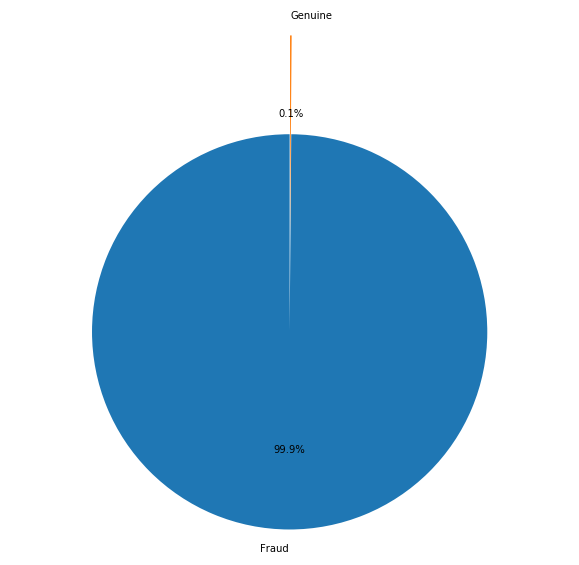


 => To do:  deal with Umbalanced data  


In [6]:
####################################### FEATURES DESCRIPTION ####################################################
#-------------------------------------------- IsFRAUD----------------------------------

#How many transcation are fraudulent?

t_size=len(df)
f_size=len(df.loc[(df.isFraud == 0)])
g_size=len(df.loc[(df.isFraud == 1)])

print ('\n Total transactions :',t_size)
print ('\n Fraudulent transactions: ',f_size) 
print ('\n Genuine transactions: ', g_size)

f, ax = plt.subplots(figsize=(10,10))
ax.pie([f_size,g_size], explode=(0.5, 0), labels=['Fraud', 'Genuine'], autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

print ('\n => To do:  deal with Umbalanced data  ')

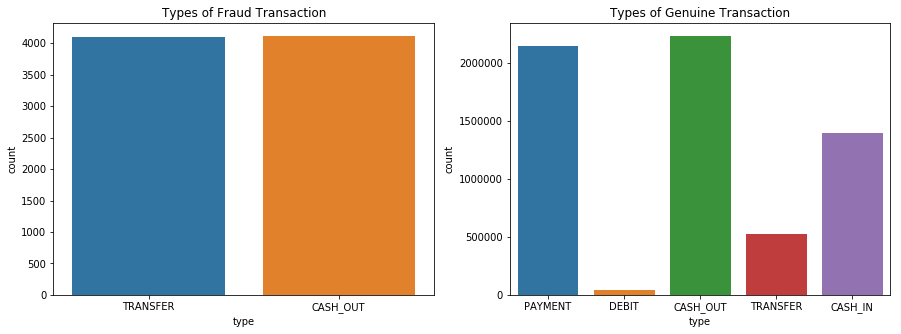


The types of fraudulent transactions are : 
CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64 

 =>To do : remove transactions with other types 
 


In [7]:
####################################### FEATURES DESCRIPTION ####################################################
#-------------------------------------------- TYPE----------------------------------

#Which types of transactions are fraudulent/important to build the model?


fraud = df[df["isFraud"] == 1]
genuine = df[df["isFraud"] == 0]

f, ax = plt.subplots(1,2,figsize=(15,5))
sns.countplot(fraud['type'], ax=ax[0])
sns.countplot(genuine['type'], ax=ax[1])
ax[0].set_title('Types of Fraud Transaction')
ax[1].set_title('Types of Genuine Transaction')
plt.show()

print('\nThe types of fraudulent transactions are : \n{} '.format(fraud.type.value_counts()))
print('\n =>To do : remove transactions with other types \n ')

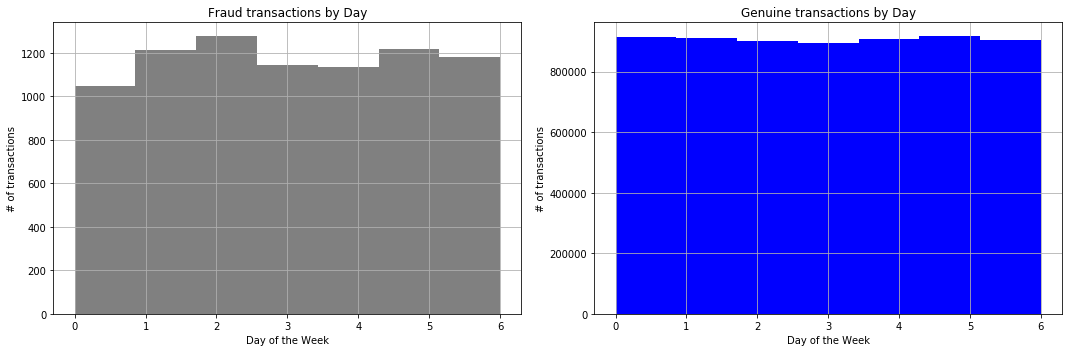

Genuine transactions and Fraudulent transactions seem to occur uniformally for each day of the week


In [8]:
####################################### FEATURES DESCRIPTION ####################################################
#-------------------------------------------- STEP----------------------------------

# Time Step by day of week

# getting hours and days of the week
num_days = 7
fraud_days = fraud.step % num_days
genuine_days = genuine.step % num_days

# plotting scatterplot of the days of the week, identifying the fraudulent transactions (red) from the valid transactions (green) 
f, ax = plt.subplots(1,2,figsize=(15,5))
fraud_days.hist(bins=num_days,color="grey",ax=ax[0])
ax[0].set_title('Fraud transactions by Day')
ax[0].set_xlabel('Day of the Week')
ax[0].set_ylabel("# of transactions")

genuine_days.hist(bins=num_days,color="blue",ax=ax[1])
ax[1].set_title('Genuine transactions by Day')
ax[1].set_xlabel('Day of the Week')
ax[1].set_ylabel("# of transactions")

plt.tight_layout()
plt.show()

print("Genuine transactions and Fraudulent transactions seem to occur uniformally for each day of the week")

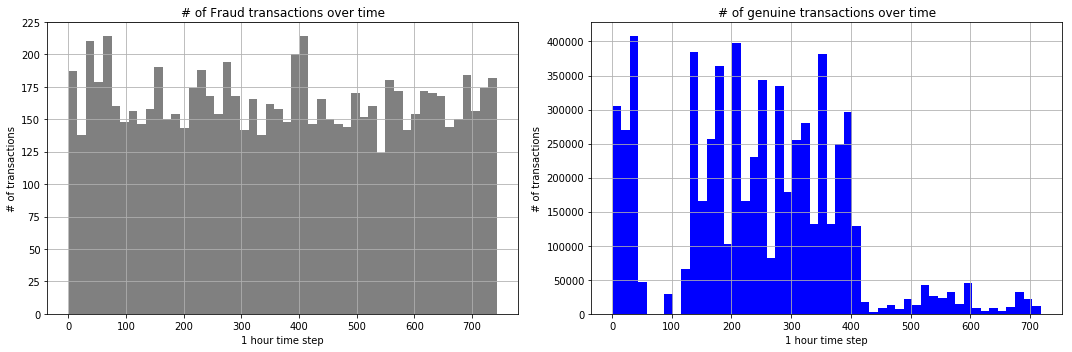

An important portion of genuine class occur between 0 and 60 timestep and between 110 and 420 
Fraudlent class doesn t change the frequency over time step


In [9]:

# Time Step by hours of day

bins = 50
f, ax = plt.subplots(1,2,figsize=(15,5))
fraud.hist(column="step",color="grey",bins=bins,ax=ax[0])
ax[0].set_xlabel("1 hour time step")
ax[0].set_ylabel("# of transactions")
ax[0].set_title("# of Fraud transactions over time")

genuine.hist(column ="step",color="blue",bins=bins,ax=ax[1])
ax[1].set_xlabel("1 hour time step")
ax[1].set_ylabel("# of transactions")
ax[1].set_title("# of genuine transactions over time")

plt.tight_layout()
plt.show()

print("An important portion of genuine class occur between 0 and 60 timestep and between 110 and 420 ")
print("Fraudlent class doesn t change the frequency over time step")

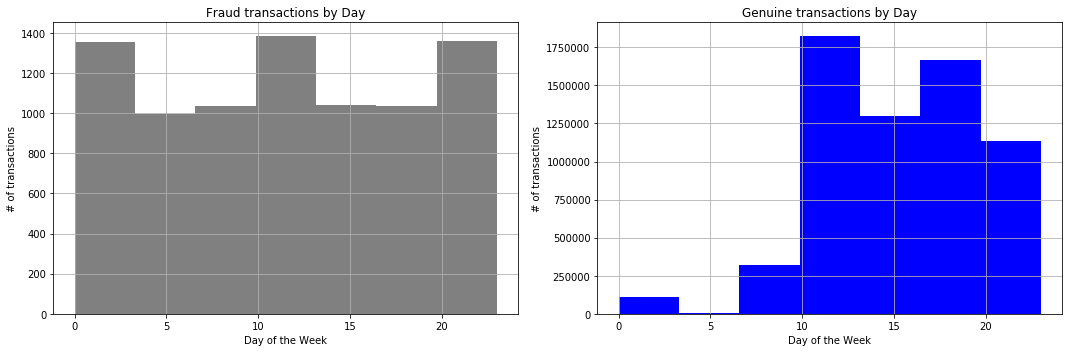

From the graphs above, there is strong evidence to suggest that from hour 0 to hour 9 genuine transactions very seldom occur.
Fraudulent transactions still occur at similar rates to any hour of the day outside of hours 0 to 9 

 => To do : add new feature  HourOfDay, which is the step column with each number taken to modulo 24 


In [10]:

# Time Step by days of week

# getting hours and days of the week
num_hours = 24
fraud_hours = fraud.step % num_hours
genuine_hours = genuine.step % num_hours

# plotting scatterplot of the days of the week, identifying the fraudulent transactions (red) from the valid transactions (green) 
f, ax = plt.subplots(1,2,figsize=(15,5))
fraud_hours.hist(bins=num_days,color="grey",ax=ax[0])
ax[0].set_title('Fraud transactions by Day')
ax[0].set_xlabel('Day of the Week')
ax[0].set_ylabel("# of transactions")

genuine_hours.hist(bins=num_days,color="blue",ax=ax[1])
ax[1].set_title('Genuine transactions by Day')
ax[1].set_xlabel('Day of the Week')
ax[1].set_ylabel("# of transactions")

plt.tight_layout()
plt.show()

print("From the graphs above, there is strong evidence to suggest that from hour 0 to hour 9 genuine transactions very seldom occur.")
print("Fraudulent transactions still occur at similar rates to any hour of the day outside of hours 0 to 9 \n")
print(" => To do : add new feature  HourOfDay, which is the step column with each number taken to modulo 24 ")

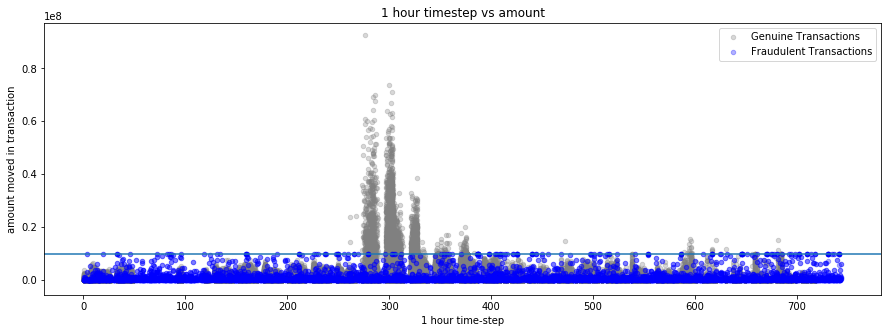

Proportion of transactions where the amount moved is greater than 10 million:  0.00038396132410862193
=> To do : remove a big part of transactions with amount more than 20 millions in the objectef to deal with unbalance pb


In [12]:
####################################### FEATURES DESCRIPTION ####################################################
#-------------------------------------------- AMOUNT----------------------------------
#genuine = genuine.loc[(genuine.amount < 20000000)]

alpha = 0.3
fig,ax = plt.subplots(1,figsize=(15,5))
genuine.plot.scatter(x="step",y="amount",color="grey",alpha=alpha,ax=ax,label="Genuine Transactions")
fraud.plot.scatter(x="step",y="amount",color="blue",alpha=alpha,ax=ax, label="Fraudulent Transactions")

plt.title("1 hour timestep vs amount")
plt.xlabel("1 hour time-step")
plt.ylabel("amount moved in transaction")
plt.legend(loc="upper right")

# plotting a horizontal line to show where valid transactions behave very differently from fraud transactions

plt.axhline(y=10000000)
plt.show()


print("Proportion of transactions where the amount moved is greater than 10 million: ", len(df[df.amount > 10000000])/len(df))
print("=> To do : remove a big part of transactions with amount more than 20 millions in the objectef to deal with unbalance pb")

In [13]:
####################################### FEATURES DESCRIPTION ####################################################
#--------------------------------------------IsFlaggedFraud----------------------------------

# What determines whether the feature isFlaggedFraud gets set or not

dfTransfer = df.loc[df.type == 'TRANSFER']
Flagged = df.loc[df.isFlaggedFraud == 1]
NotFlagged = df.loc[df.isFlaggedFraud == 0]


print ('\nThe number of isFlaggedFraud transaction : {}'.format(len(Flagged))) 
print('\nThe type of transactions in which isFlaggedFraud is set: {}'.format(list(Flagged.type.drop_duplicates()))) 
print('\nMin amount transacted when isFlaggedFraud is set: {}'.format(Flagged.amount.min())) 
print('\nMax amount transacted in a TRANSFER where isFlaggedFraud is not set:{}'.format(dfTransfer.loc[dfTransfer.isFlaggedFraud == 0].amount.max()))

print('\n => A transaction with "TRANSFER" an "amount" greater than 200,000 is not enougth to set isFlaggedFraud to 1')
print('\n => We are going to develop a new fraud detection that does not depend on a pre-existing fraud detection')
print('\n => To do :let s just remove this feature!!')


The number of isFlaggedFraud transaction : 16

The type of transactions in which isFlaggedFraud is set: ['TRANSFER']

Min amount transacted when isFlaggedFraud is set: 353874.22

Max amount transacted in a TRANSFER where isFlaggedFraud is not set:92445516.64

 => A transaction with "TRANSFER" an "amount" greater than 200,000 is not enougth to set isFlaggedFraud to 1

 => We are going to develop a new fraud detection that does not depend on a pre-existing fraud detection

 => To do :let s just remove this feature!!


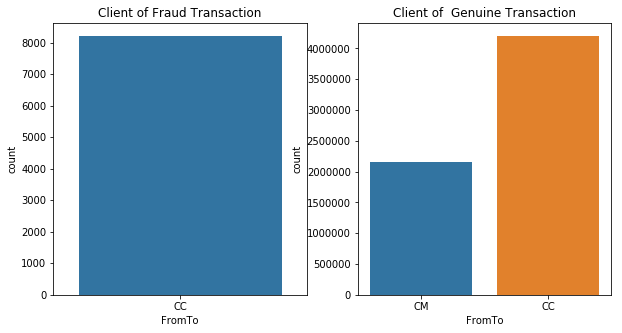

 => To do : remove all transaction with types different to CC


In [14]:
####################################### FEATURES DESCRIPTION ####################################################
#--------------------------------------------NameOrig and nameDest ----------------------------------


#Are expected merchant accounts accordingly labelled?

df["FromTo"] = np.nan 

# filling feature column
df.loc[df.nameOrig.str.contains('C') & df.nameDest.str.contains('C'),"FromTo"] = "CC" 
df.loc[df.nameOrig.str.contains('C') & df.nameDest.str.contains('M'),"FromTo"] = "CM"
df.loc[df.nameOrig.str.contains('M') & df.nameDest.str.contains('C'),"FromTo"] = "MC"
df.loc[df.nameOrig.str.contains('M') & df.nameDest.str.contains('M'),"FromTo"] = "MM"

# Subsetting data into observations with fraud and valid transactions:
fraud = df[df["isFraud"] == 1]
valid = df[df["isFraud"] == 0]

# seeing the counts of transactions by type1 (CC,CM,MC,MM)
#print("Fraud transactions by fromTo: \n",fraud.FromTo.value_counts())
#print("\n Valid transactions by fromTo: \n ",valid.FromTo.value_counts())

f, ax = plt.subplots(1,2,figsize=(10,5))
sns.countplot(fraud['FromTo'], ax=ax[0])
sns.countplot(valid['FromTo'], ax=ax[1])
ax[0].set_title('Client of Fraud Transaction')
ax[1].set_title('Client of  Genuine Transaction')

plt.show()

print(' => To do : remove all transaction with types different to CC')

In [15]:
#Are there account labels common to fraudulent TRANSFERs and CASH_OUTs?

print("\n Normaly the fraudulent behavior of the agents aims to profit by taking control or customers \n \
        accounts and try to empty the funds by transferring to another account and then cashing out of the system")

# separating transfers and cashouts for fraud accounts
fraud_transfer = fraud[fraud["type"] == "TRANSFER"]
fraud_cashout = fraud[fraud["type"] == "CASH_OUT"]

# checking if the recipient account of a fraudulent transfer was used as a sending account for cashing out 
print("\nThe recipient account of a fraudulent transfer was used as a sending account for cashing out:",fraud_transfer.nameDest.isin(fraud_cashout.nameOrig).any()
)
print("\n => To do : drop these features from the data since they are meaningless")


 Normaly the fraudulent behavior of the agents aims to profit by taking control or customers 
         accounts and try to empty the funds by transferring to another account and then cashing out of the system

The recipient account of a fraudulent transfer was used as a sending account for cashing out: False

 => To do : drop these features from the data since they are meaningless


Percentage of observations with balance errors:  100 %
---------------- errorBalanceOrig Class ---------------------

------Summary statistics of errorBalanceOrig for fraudulent transactions: 
 count    8.213000e+03
mean     1.069233e+04
std      2.651461e+05
min     -7.450581e-09
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+07
Name: errorBalanceOrig, dtype: float64

------Summary statistics of errorBalanceOrig for valid transactions: 
 count    6.354407e+06
mean     2.013386e+05
std      6.069289e+05
min     -1.000000e-02
25%      3.034305e+03
50%      6.904931e+04
75%      2.499534e+05
max      9.244552e+07
Name: errorBalanceOrig, dtype: float64


C:\Users\souad\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


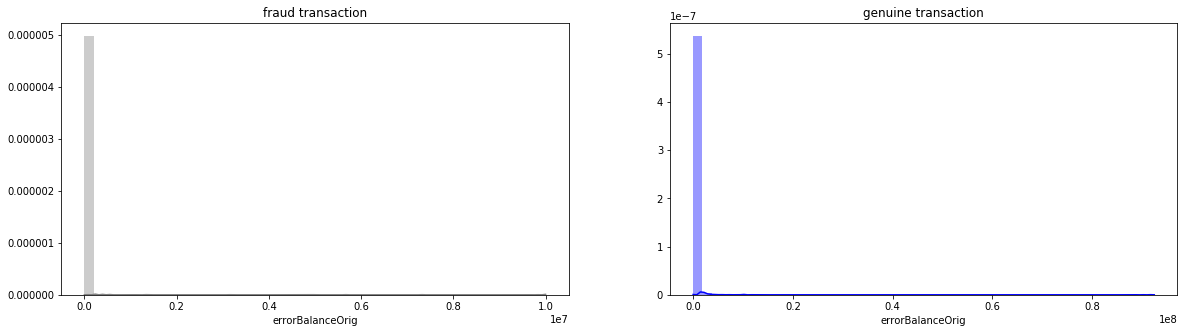

 =>  it seems that a large proportion of the data have an error of 0 or close to zero.This is indicated by the fact that the most negative error is -7.450581e-09 or −7.450581x10−9 which is very small and close to 0,and the 3rd quartile is 0 (that is, about 75% of the data is between -7.450581e-09 and 0). However, there are some large errors, the largest error being 10,000,000.
 for valid transactions, a large proportion of the data have large errors. For instance, about 75% of the data haver errorsexceeding 52,613.43 (the first quartile). The largest error is 92,445,520.


In [16]:
####################################### FEATURES DESCRIPTION ####################################################
#---------------------------------   OLD/NEW BALANCE DEST/ORIG -------------------------------------


#Missing data in balances ?
#C1305486145 transfered 181.0 to C553264065 and the balance of C1305486145 decreased by181.0. But why does the balance of the destination C553264065 remain zero?
#df.query('step == 1 and (nameOrig == "C553264065" or nameDest == "C553264065")')

num_wrong_bal = (df["oldBalanceOrig"] - df["amount"] != df["newBalanceOrig"]) | (df["newBalanceDest"] + df["amount"] != df["newBalanceDest"])
print("Percentage of observations with balance errors: ", 100*round(sum(num_wrong_bal)/len(df)),'%')


#we have data for the account at origin but not for the account at the destination - 
#perhaps it isn't an account that is registered with the company => missing data

# adding features errorBalanceOrg, errorBalanceDest
df["errorBalanceOrig"] = df.newBalanceOrig + df.amount - df.oldBalanceOrig
df["errorBalanceDest"] = df.oldBalanceDest + df.amount - df.newBalanceDest


# Subsetting data into observations with fraud and valid transactions:
fraud = df[df["isFraud"] == 1]
genuine = df[df["isFraud"] == 0]

print("---------------- errorBalanceOrig Class ---------------------")

print("\n------Summary statistics of errorBalanceOrig for fraudulent transactions: \n",fraud["errorBalanceOrig"].describe())
print("\n------Summary statistics of errorBalanceOrig for valid transactions: \n",genuine["errorBalanceOrig"].describe())

f, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(fraud["errorBalanceOrig"],ax=ax[0],color="grey")
sns.distplot(genuine["errorBalanceOrig"],ax=ax[1],color="blue")
ax[0].set_title("fraud transaction")
ax[1].set_title("genuine transaction")
plt.show()

print(" =>  it seems that a large proportion of the data have an error of 0 or close to zero.\
This is indicated by the fact that the most negative error is -7.450581e-09 or −7.450581x10−9 which is very small and close to 0,\
and the 3rd quartile is 0 (that is, about 75% of the data is between -7.450581e-09 and 0). However, there are some large errors, \
the largest error being 10,000,000.")

print(" for valid transactions, a large proportion of the data have large errors. For instance, about 75% of the data haver errors\
exceeding 52,613.43 (the first quartile). The largest error is 92,445,520.")

---------------- errorBalanceDest Class ---------------------

------Summary statistics of errorBalanceDest for fraudulent transactions: 
 count    8.213000e+03
mean     7.325093e+05
std      1.867748e+06
min     -8.875516e+06
25%      0.000000e+00
50%      2.231460e+03
75%      4.427220e+05
max      1.000000e+07
Name: errorBalanceDest, dtype: float64

------Summary statistics of errorBalanceDest for valid transactions: 
 count    6.354407e+06
mean     5.469223e+04
std      4.360026e+05
min     -7.588573e+07
25%      0.000000e+00
50%      3.500680e+03
75%      2.925981e+04
max      1.319123e+07
Name: errorBalanceDest, dtype: float64


C:\Users\souad\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


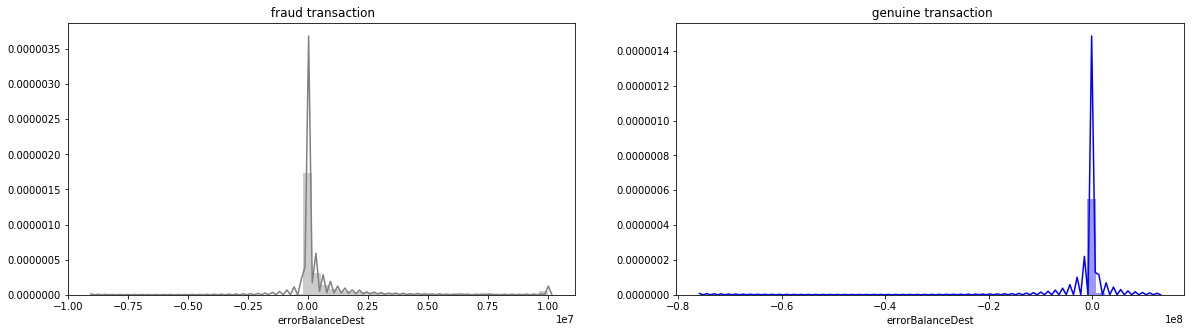

From the summary statistics of the errorBalanceDest variable, the errors are huge in both directions (both fraudulent and validtransactions have large positive and negative errors in the accounts where money has been moved to.)


In [17]:
print("---------------- errorBalanceDest Class ---------------------")

print("\n------Summary statistics of errorBalanceDest for fraudulent transactions: \n",fraud["errorBalanceDest"].describe())
print("\n------Summary statistics of errorBalanceDest for valid transactions: \n",genuine["errorBalanceDest"].describe())

f, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(fraud["errorBalanceDest"],ax=ax[0],color="grey")
sns.distplot(genuine["errorBalanceDest"],ax=ax[1],color="blue")

ax[0].set_title(" fraud transaction")
ax[1].set_title(" genuine transaction")
plt.show()

print("From the summary statistics of the errorBalanceDest variable, the errors are huge in both directions (both fraudulent and valid\
transactions have large positive and negative errors in the accounts where money has been moved to.)")

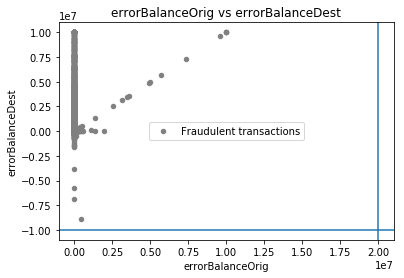

 => errors in both the balanceOrg and balanceDest variables are large, however for:
      Genuine transactions  errorBalanceOrig > 0.
      Fraudulent transactions have more errorBalanceDest > 0 than genuine transactions.
      Genuine transactions have errorBalanceDest > 10,000,000

 These distinctions and probably more, make errorBalanceDest and errorBalanceOrg potentially effective features
=> To do : add new features of errorBalanceDest and errorBalanceOrg
=> To do : to dealing with balanced data we choose data with errorBalanceDest>-1000000 and errorBalanceOrig<2000000


In [19]:
#----------------------Balance features

errors = ["errorBalanceOrig", "errorBalanceDest"]
ax = plt.subplot()

plt.axhline(y=-10000000)
plt.axvline(x=20000000)
fplot = fraud.plot(x="errorBalanceOrig",y="errorBalanceDest",color="grey",kind="scatter",ax=ax,label="Fraudulent transactions")
#gplot = genuine.plot(x="errorBalanceOrig",y="errorBalanceDest",color="blue",kind="scatter",alpha=0.05,ax=ax,label="Genuine transactions")
plt.title("errorBalanceOrig vs errorBalanceDest")
plt.show()

print(" => errors in both the balanceOrg and balanceDest variables are large, however for:\n \
     Genuine transactions  errorBalanceOrig > 0.\n \
     Fraudulent transactions have more errorBalanceDest > 0 than genuine transactions.\n \
     Genuine transactions have errorBalanceDest > 10,000,000\n\n \
These distinctions and probably more, make errorBalanceDest and errorBalanceOrg potentially effective features")
print("=> To do : add new features of errorBalanceDest and errorBalanceOrg")
print("=> To do : to dealing with balanced data we choose data with errorBalanceDest>-1000000 and errorBalanceOrig<2000000")

In [28]:
print("errorBalanceDest :", len(df.loc[(df.errorBalanceDest>=-10000000) & (df.errorBalanceOrig<=20000000)] ))

errorBalanceDest : 6360176


In [34]:
#----------------------Balance features after removing amount more than 20 millions
genuine = genuine.loc[(genuine.amount < 20000000)]

errors = ["errorBalanceOrig", "errorBalanceDest"]
ax = plt.subplot()


plt.axhline(y=-10000000)
plt.axvline(x=20000000)

fplot = fraud.plot(x="errorBalanceOrig",y="errorBalanceDest",color="grey",kind="scatter",ax=ax,label="Fraudulent transactions")
gplot = genuine.plot(x="errorBalanceOrig",y="errorBalanceDest",color="blue",kind="scatter",alpha=1,ax=ax,label="Genuine transactions")
plt.title("errorBalanceOrig vs errorBalanceDest")
plt.show()

print(" => The spread of errors in both the balanceOrg and balanceDest variables are large, however valid transactions\
are much more likely to have an errorBalanceOrg > 0.\n \
Similarly, fraudulent transactions are much more likely to have errorBalanceDest > 0 than valid transactions.\n \
In addition, only valid transactions have errorBalanceDest > 10,000,000\n \
These distinctions and probably more, make errorBalanceDest and errorBalanceOrg potentially effective features")

MemoryError: 